# Time Series Data Processing

**Date:** 2025-10-25

This notebook demonstrates the core skills for processing time-stamped data in Python.
- Parsing timestamps & time zones
- Resampling (down/upsampling) and aggregation
- Revealing/handling gaps and imputation
- Rolling smoothing & simple outlier flags
- Seasonal baselines and time-aware evaluation

We use three datasets:
1. **Wikipedia Pageviews** for Vietnamese topics (daily)
2. **Hanoi Hourly Weather** via Meteostat (hourly → daily)
3. **Hanoi PM2.5 Air Quality** via Open‑Meteo (hourly → daily)


## 0) Setup

If needed, install the small dependencies. We stick to **matplotlib** for plots (one chart per figure, no custom colors).


In [1]:
# If needed, uncomment to install:
# %pip install --quiet requests meteostat statsmodels

In [2]:
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import requests as rq

In [3]:
# Plot helpers
# One chart per figure, no explicit colors
def plot_series(s, title=None, ylabel=None, rotation=None):
    fig = plt.figure()
    plt.plot(s.index, s.values)
    if title: plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(ylabel if ylabel else (s.name if s.name else "value"))

    if rotation:
        plt.xticks(rotation=rotation)

    plt.tight_layout()
    plt.show()

# Two charts per figure, no explicit colors
def plot_two_series(a, b, title=None, ylabel=None, legend=("A","B"), rotation=None):
    fig = plt.figure()
    plt.plot(a.index, a.values, label=legend[0])
    plt.plot(b.index, b.values, label=legend[1])
    if title: plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(ylabel if ylabel else (a.name or "value"))
    plt.legend()

    if rotation:
        plt.xticks(rotation=rotation)
    
    plt.tight_layout()
    plt.show()

LOCAL_TZ = "Asia/Ho_Chi_Minh"  # Hanoi timezone
TODAY_UTC = datetime.datetime.now(datetime.UTC).date()

---
## 1) Wikipedia Pageviews — Vietnam & Hanoi (daily)

**Step A — Fetch & parse:** Use the Wikimedia REST API to get daily pageviews for topics like **Vietnam** and **Hanoi**.


In [4]:
ARTICLE = "Vietnam"  # Wikipedia article, try "Hanoi" too

# Set time period of interest
START = "20150701" # Start date: July 1, 2015
END = datetime.datetime.now(datetime.UTC).strftime("%Y%m%d") # End date: today

# Fetch pageview data from Wikimedia REST API
url = (
    "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/"
    f"en.wikipedia.org/all-access/all-agents/{ARTICLE}/daily/{START}/{END}"
)
headers = {"User-Agent": "HanoiTimeSeriesClass/1.0 (contact: instructor@example.com)"}
items = rq.get(url, headers=headers).json()["items"]

In [5]:
# Preview first 3 items
items[:3]

[{'project': 'en.wikipedia',
  'article': 'Vietnam',
  'granularity': 'daily',
  'timestamp': '2015070100',
  'access': 'all-access',
  'agent': 'all-agents',
  'views': 7762},
 {'project': 'en.wikipedia',
  'article': 'Vietnam',
  'granularity': 'daily',
  'timestamp': '2015070200',
  'access': 'all-access',
  'agent': 'all-agents',
  'views': 7885},
 {'project': 'en.wikipedia',
  'article': 'Vietnam',
  'granularity': 'daily',
  'timestamp': '2015070300',
  'access': 'all-access',
  'agent': 'all-agents',
  'views': 8810}]

In [6]:
# Convert to DataFrame
pv = pd.DataFrame(items)
pv

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Vietnam,daily,2015070100,all-access,all-agents,7762
1,en.wikipedia,Vietnam,daily,2015070200,all-access,all-agents,7885
2,en.wikipedia,Vietnam,daily,2015070300,all-access,all-agents,8810
3,en.wikipedia,Vietnam,daily,2015070400,all-access,all-agents,7796
4,en.wikipedia,Vietnam,daily,2015070500,all-access,all-agents,7896
...,...,...,...,...,...,...,...
3764,en.wikipedia,Vietnam,daily,2025102000,all-access,all-agents,8605
3765,en.wikipedia,Vietnam,daily,2025102100,all-access,all-agents,9732
3766,en.wikipedia,Vietnam,daily,2025102200,all-access,all-agents,9148
3767,en.wikipedia,Vietnam,daily,2025102300,all-access,all-agents,9175


In [7]:
# Parse timestamps into datetime
pv["ts"] = pd.to_datetime(pv["timestamp"], format="%Y%m%d%H", utc=True)
pv.head()

,project,article,granularity,timestamp,access,agent,views,ts
0,en.wikipedia,Vietnam,daily,2015070100,all-access,all-agents,7762,2015-07-01 00:00:00+00:00
1,en.wikipedia,Vietnam,daily,2015070200,all-access,all-agents,7885,2015-07-02 00:00:00+00:00
2,en.wikipedia,Vietnam,daily,2015070300,all-access,all-agents,8810,2015-07-03 00:00:00+00:00
3,en.wikipedia,Vietnam,daily,2015070400,all-access,all-agents,7796,2015-07-04 00:00:00+00:00
4,en.wikipedia,Vietnam,daily,2015070500,all-access,all-agents,7896,2015-07-05 00:00:00+00:00


In [8]:
# Set datetime index and sort
pv = pv.set_index("ts").sort_index()
pv_daily = pv["views"]
pv_daily.name = f"{ARTICLE} daily pageviews"
pv_daily.head()

ts
2015-07-01 00:00:00+00:00    7762
2015-07-02 00:00:00+00:00    7885
2015-07-03 00:00:00+00:00    8810
2015-07-04 00:00:00+00:00    7796
2015-07-05 00:00:00+00:00    7896
Name: Vietnam daily pageviews, dtype: int64

**Step B — Visualize & smooth:**

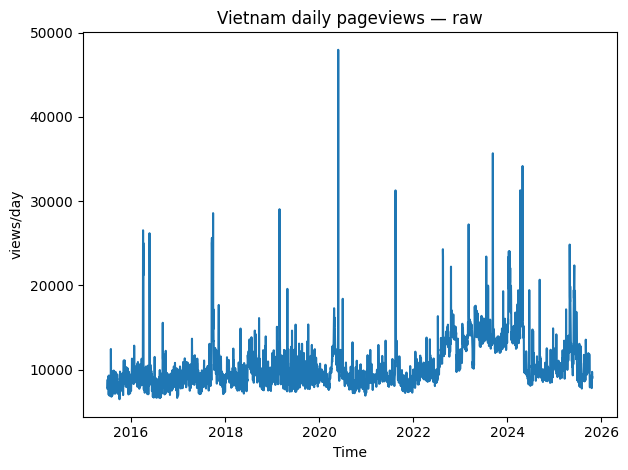

In [9]:
# Plot raw counts
plot_series(pv_daily, title=f"{pv_daily.name} — raw", ylabel="views/day")

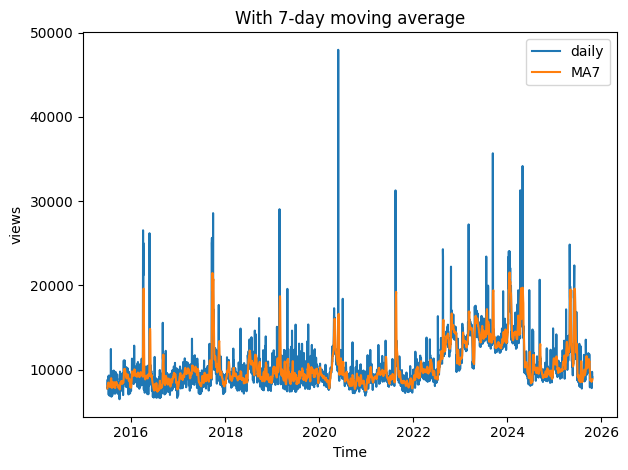

In [10]:
# 7-day moving average (MA7), equation: MA7_t = (X_t + X_{t-1} + ... + X_{t-6}) / 7
pv_ma7 = pv_daily.rolling(7, min_periods=1).mean()

# Plot both series: raw and MA7
plot_two_series(pv_daily, pv_ma7, title="With 7-day moving average", ylabel="views", legend=("daily","MA7"))

**Step C — Weekly seasonality via resampling:**

ts
2015-07-05 00:00:00+00:00    40149
2015-07-12 00:00:00+00:00    56830
2015-07-19 00:00:00+00:00    56642
2015-07-26 00:00:00+00:00    57851
2015-08-02 00:00:00+00:00    60927
                             ...  
2025-09-28 00:00:00+00:00    76133
2025-10-05 00:00:00+00:00    67208
2025-10-12 00:00:00+00:00    61477
2025-10-19 00:00:00+00:00    60334
2025-10-26 00:00:00+00:00    45701
Freq: W-SUN, Name: Vietnam daily pageviews, Length: 539, dtype: int64

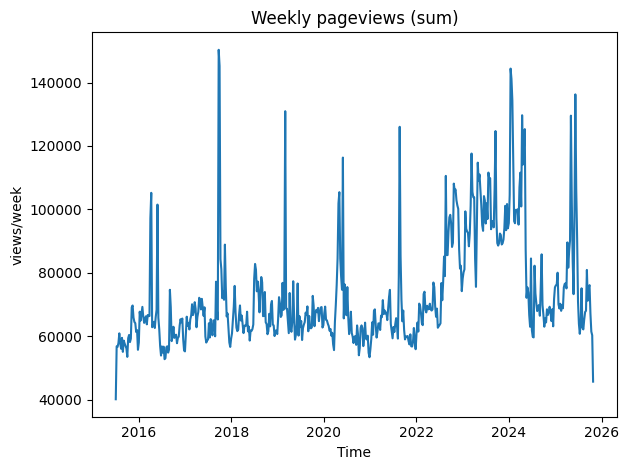

In [11]:
# Resample to weekly frequency (sum of daily views per week)
# What does the function .resample() do here? It groups data into weekly ("W") bins and applies the sum function.
pv_weekly = pv_daily.resample("W").sum()
display(pv_weekly)
plot_series(pv_weekly, title="Weekly pageviews (sum)", ylabel="views/week")

---
## 2) Hanoi Hourly Weather — Meteostat (hourly → daily)

**Step A — Fetch:** Get hourly weather for **Hanoi** and convert to local time.


In [12]:
from meteostat import Hourly, Point

hanoi = Point(21.028, 105.834)  # Latitude, Longitude of Hanoi

# Set time period: from Jan 1, 2019 to today
start, end = datetime.datetime(2019,1,1), datetime.datetime.now(datetime.UTC).replace(tzinfo=None)

# Fetch hourly weather data
wx = Hourly(hanoi, start, end).fetch()        # tz-aware (UTC)

# Convert to local timezone
if wx.index.tz is None:
    wx = wx.tz_localize("UTC")
wx = wx.tz_convert(LOCAL_TZ)

# Preview first 5 rows
wx.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2019-01-01 07:00:00+07:00,11.0,4.0,62.0,<NA>,<NA>,30.0,16.6,<NA>,1029.0,<NA>,4.0
2019-01-01 08:00:00+07:00,11.0,4.9,66.0,<NA>,<NA>,10.0,14.8,<NA>,1030.0,<NA>,4.0
2019-01-01 09:00:00+07:00,11.0,4.0,62.0,<NA>,<NA>,10.0,16.6,<NA>,1031.0,<NA>,4.0
2019-01-01 10:00:00+07:00,11.0,4.9,66.0,<NA>,<NA>,10.0,14.8,<NA>,1030.0,<NA>,4.0
2019-01-01 11:00:00+07:00,12.0,4.9,62.0,<NA>,<NA>,10.0,18.4,<NA>,1030.0,<NA>,4.0


**Step B — Daily aggregates:**

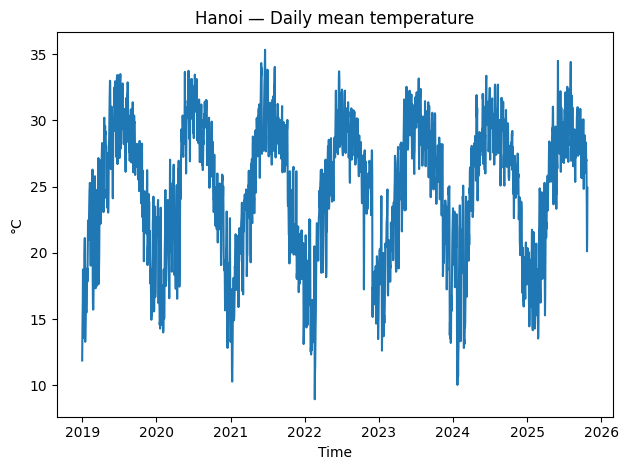

In [13]:
# Temperature (°C)
daily_temp = wx["temp"].resample("D").mean()     # air temperature, daily ("D") average, insert missing days as rows with NaN
daily_temp.name = "Daily mean temperature (°C)"
plot_series(daily_temp, title="Hanoi — Daily mean temperature", ylabel="°C")

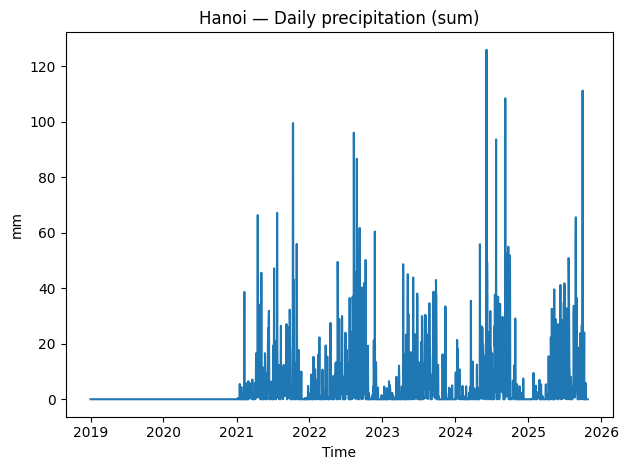

In [14]:
# Precipitation (mm)
daily_prcp = wx["prcp"].resample("D").sum()      # daily precipitation sum
daily_prcp.name = "Daily precipitation (mm)"
plot_series(daily_prcp, title="Hanoi — Daily precipitation (sum)", ylabel="mm")

**Step C — Handle gaps & smooth:**

In [15]:
# Impute small gaps
# What does .interpolate("time") and .ffill() do here? It fills missing values by interpolating over time and forward-filling.
daily_temp_filled = daily_temp.interpolate("time").ffill()
print(f"Number of missing days filled: {(daily_temp_filled.isna().sum())} (out of {len(daily_temp)})")
display(daily_temp)
display(daily_temp_filled)

Number of missing days filled: 0 (out of 2490)


time
2019-01-01 00:00:00+07:00    11.882353
2019-01-02 00:00:00+07:00    14.041667
2019-01-03 00:00:00+07:00    15.166667
2019-01-04 00:00:00+07:00       16.125
2019-01-05 00:00:00+07:00        18.75
                               ...    
2025-10-21 00:00:00+07:00    25.333333
2025-10-22 00:00:00+07:00         23.5
2025-10-23 00:00:00+07:00       20.125
2025-10-24 00:00:00+07:00    21.154167
2025-10-25 00:00:00+07:00    24.916667
Freq: D, Name: Daily mean temperature (°C), Length: 2490, dtype: Float64

time
2019-01-01 00:00:00+07:00    11.882353
2019-01-02 00:00:00+07:00    14.041667
2019-01-03 00:00:00+07:00    15.166667
2019-01-04 00:00:00+07:00       16.125
2019-01-05 00:00:00+07:00        18.75
                               ...    
2025-10-21 00:00:00+07:00    25.333333
2025-10-22 00:00:00+07:00         23.5
2025-10-23 00:00:00+07:00       20.125
2025-10-24 00:00:00+07:00    21.154167
2025-10-25 00:00:00+07:00    24.916667
Freq: D, Name: Daily mean temperature (°C), Length: 2490, dtype: Float64

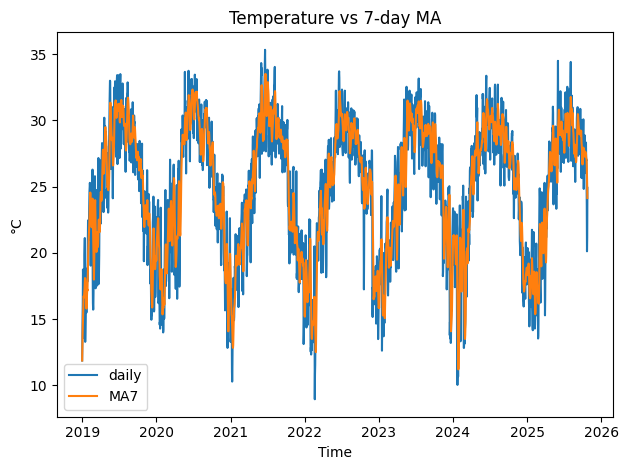

In [16]:
# Rolling smoothing (Moving averaging - MA)
ma7_temp = daily_temp_filled.rolling(7, min_periods=1).mean()

# Plot both series: daily filled and MA7
plot_two_series(daily_temp_filled, ma7_temp, title="Temperature vs 7-day MA", ylabel="°C", legend=("daily","MA7"))

**Step D — Outlier flag (rolling z-score):**

In [17]:
# Rolling statistics: 30-day window, at least 15 non-NA days required
roll = daily_temp_filled.rolling("30D", min_periods=15)
mu, sd = roll.mean(), roll.std()
display(mu.head(20))
display(sd.head(20))

time
2019-01-01 00:00:00+07:00          NaN
2019-01-02 00:00:00+07:00          NaN
2019-01-03 00:00:00+07:00          NaN
2019-01-04 00:00:00+07:00          NaN
2019-01-05 00:00:00+07:00          NaN
2019-01-06 00:00:00+07:00          NaN
2019-01-07 00:00:00+07:00          NaN
2019-01-08 00:00:00+07:00          NaN
2019-01-09 00:00:00+07:00          NaN
2019-01-10 00:00:00+07:00          NaN
2019-01-11 00:00:00+07:00          NaN
2019-01-12 00:00:00+07:00          NaN
2019-01-13 00:00:00+07:00          NaN
2019-01-14 00:00:00+07:00          NaN
2019-01-15 00:00:00+07:00    17.053268
2019-01-16 00:00:00+07:00    16.818168
2019-01-17 00:00:00+07:00    16.662197
2019-01-18 00:00:00+07:00    16.583742
2019-01-19 00:00:00+07:00    16.656089
2019-01-20 00:00:00+07:00    16.754534
Freq: D, Name: Daily mean temperature (°C), dtype: float64

time
2019-01-01 00:00:00+07:00         NaN
2019-01-02 00:00:00+07:00         NaN
2019-01-03 00:00:00+07:00         NaN
2019-01-04 00:00:00+07:00         NaN
2019-01-05 00:00:00+07:00         NaN
2019-01-06 00:00:00+07:00         NaN
2019-01-07 00:00:00+07:00         NaN
2019-01-08 00:00:00+07:00         NaN
2019-01-09 00:00:00+07:00         NaN
2019-01-10 00:00:00+07:00         NaN
2019-01-11 00:00:00+07:00         NaN
2019-01-12 00:00:00+07:00         NaN
2019-01-13 00:00:00+07:00         NaN
2019-01-14 00:00:00+07:00         NaN
2019-01-15 00:00:00+07:00    2.714944
2019-01-16 00:00:00+07:00    2.786374
2019-01-17 00:00:00+07:00    2.773480
2019-01-18 00:00:00+07:00    2.711182
2019-01-19 00:00:00+07:00    2.653600
2019-01-20 00:00:00+07:00    2.620079
Freq: D, Name: Daily mean temperature (°C), dtype: float64

In [18]:
# Identify outliers using z-score
z = (daily_temp_filled - mu) / sd

# Outliers: |z| > 3
temp_outliers = daily_temp_filled[z.abs() > 3]

print("Outlier days (|z|>3):", int(temp_outliers.count()))
display(temp_outliers)

Outlier days (|z|>3): 7


time
2021-12-27 00:00:00+07:00       13.125
2022-10-20 00:00:00+07:00        17.25
2022-12-01 00:00:00+07:00       15.375
2022-12-02 00:00:00+07:00    15.166667
2023-11-13 00:00:00+07:00        18.25
2023-11-14 00:00:00+07:00    18.583333
2025-10-23 00:00:00+07:00       20.125
Name: Daily mean temperature (°C), dtype: Float64

**Question**: Why would those days be outliers? Let's inspect one of them.

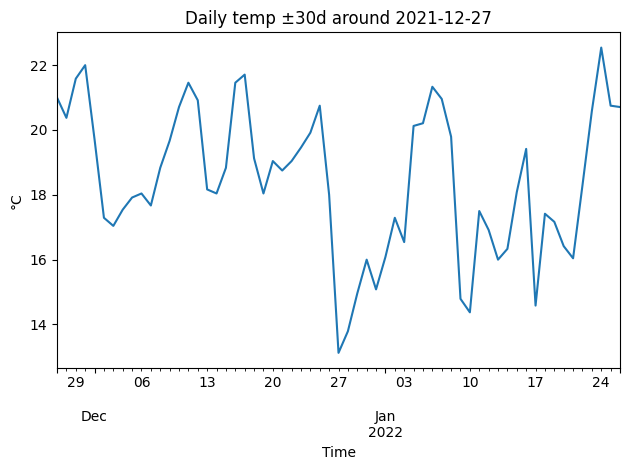

In [19]:
# Anchor date in the series
anchor = temp_outliers.index[0]

# Window to inspect
k = 30 # days before/after
win = slice(anchor - pd.Timedelta(days=k), anchor + pd.Timedelta(days=k))

# Plot daily temp around the anchor date
ax = daily_temp_filled.loc[win].plot(title=f"Daily temp ±{k}d around {anchor.date()}", ylabel="°C", xlabel="Time")
plt.tight_layout()
plt.show()

**Step E — Seasonality by month & day-of-week:**

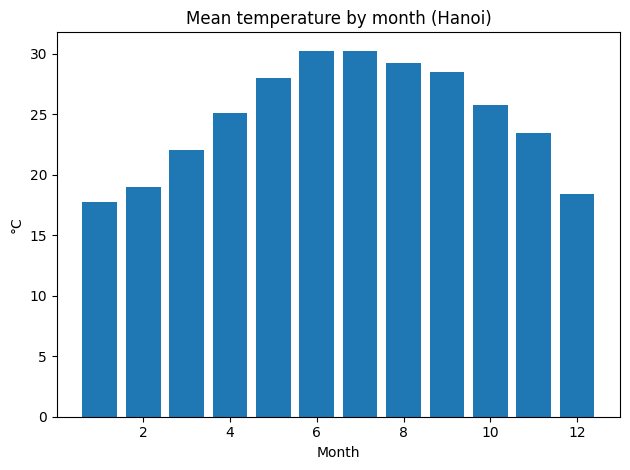

In [20]:
# Mean temperature by month
month_mean = daily_temp_filled.groupby(daily_temp_filled.index.month).mean()

# Plot mean temperature by month
fig = plt.figure()
plt.bar(range(1,13), month_mean.values)
plt.title("Mean temperature by month (Hanoi)")
plt.xlabel("Month")
plt.ylabel("°C")
plt.tight_layout()
plt.show()

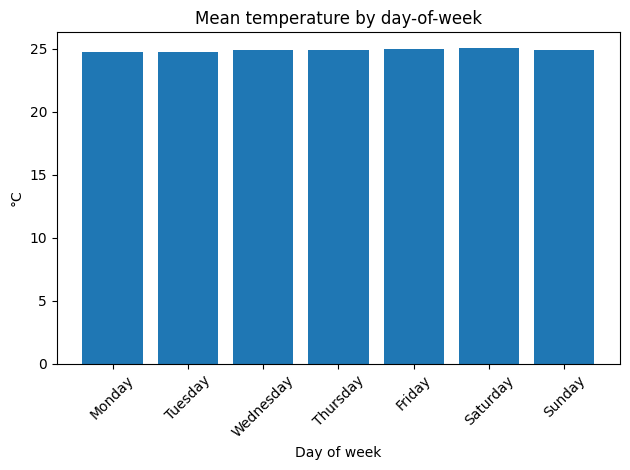

In [21]:
# Mean temperature by day-of-week
dow_mean = daily_temp_filled.groupby(daily_temp_filled.index.dayofweek).mean()

# Plot mean temperature by day-of-week
fig = plt.figure()
plt.bar(range(7), dow_mean.values)
plt.title("Mean temperature by day-of-week")
plt.xlabel("Day of week")
plt.ylabel("°C")
plt.xticks(range(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=45)
plt.tight_layout()
plt.show()

---
## 3) Hanoi PM2.5 — Open‑Meteo Air Quality (hourly → daily)

**Step A — Fetch:** Pull hourly **PM2.5** estimates for Hanoi and convert them to a time-indexed series.


In [22]:
# Set location and time period
lat, lon = 21.028, 105.834
start_date = "2019-01-01"
end_date = datetime.datetime.now(datetime.UTC).date().isoformat()

# Fetch air quality data from Open-Meteo Air Quality API
aq_url = (
    "https://air-quality-api.open-meteo.com/v1/air-quality"
    f"?latitude={lat}&longitude={lon}"
    f"&hourly=pm2_5&start_date={start_date}&end_date={end_date}"
    f"&timezone={LOCAL_TZ}"
)
aq = rq.get(aq_url).json()

# Inspect the data
print(aq.keys())
print(aq["hourly"].keys())

dict_keys(['latitude', 'longitude', 'generationtime_ms', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation', 'elevation', 'hourly_units', 'hourly'])
dict_keys(['time', 'pm2_5'])


In [23]:
# Convert to Pandas Series
aq_time = pd.to_datetime(aq["hourly"]["time"])
pm25 = pd.Series(aq["hourly"]["pm2_5"], index=aq_time, name="PM2.5 (µg/m³)")
pm25 = pm25.sort_index()

pm25

2019-01-01 00:00:00     NaN
2019-01-01 01:00:00     NaN
2019-01-01 02:00:00     NaN
2019-01-01 03:00:00     NaN
2019-01-01 04:00:00     NaN
                       ... 
2025-10-25 19:00:00    48.1
2025-10-25 20:00:00    47.5
2025-10-25 21:00:00    46.2
2025-10-25 22:00:00    44.6
2025-10-25 23:00:00    41.9
Name: PM2.5 (µg/m³), Length: 59760, dtype: float64

**Step B — Daily aggregation, gaps, smoothing:**

2019-01-01          NaN
2019-01-02          NaN
2019-01-03          NaN
2019-01-04          NaN
2019-01-05          NaN
                ...    
2025-10-21    17.491667
2025-10-22    16.466667
2025-10-23    20.004167
2025-10-24    32.887500
2025-10-25    37.712500
Freq: D, Name: PM2.5 (µg/m³), Length: 2490, dtype: float64

2022-08-04    46.641176
2022-08-05    33.112500
2022-08-06    28.566667
2022-08-07    26.070833
2022-08-08    25.625000
                ...    
2025-10-21    17.491667
2025-10-22    16.466667
2025-10-23    20.004167
2025-10-24    32.887500
2025-10-25    37.712500
Freq: D, Name: PM2.5 (µg/m³), Length: 1179, dtype: float64

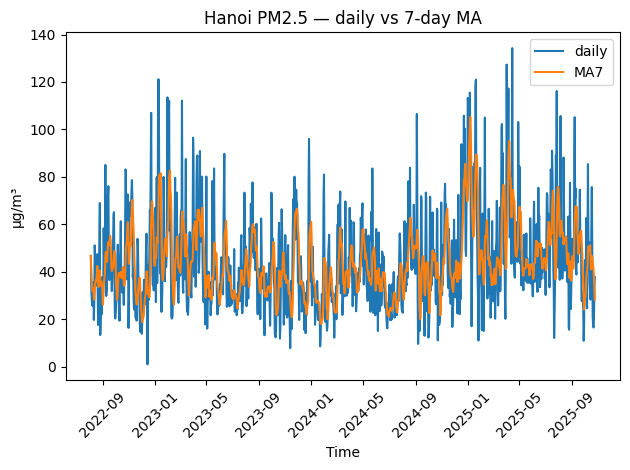

In [24]:
# Daily average PM2.5
pm25_daily = pm25.resample("D").mean()

# Fill missing days by interpolation and forward-fill
pm25_daily_filled = pm25_daily.interpolate("time").ffill()
display(pm25_daily_filled)

# Remove any remaining NaN values (i.e., at the beginning)
pm25_daily_filled = pm25_daily_filled.dropna()
display(pm25_daily_filled)

# 7-day moving average
ma7_pm25 = pm25_daily_filled.rolling(7, min_periods=1).mean()

# Plot both series: daily filled and MA7
plot_two_series(pm25_daily_filled, ma7_pm25, title="Hanoi PM2.5 — daily vs 7-day MA", ylabel="µg/m³", legend=("daily","MA7"), rotation=45)

**Step C — Episode counting vs WHO guideline (24h):**
World Health Organization 24-hour guideline for PM2.5 is **15 µg/m³** (2021 update). We'll count days above this threshold.


In [25]:

threshold = 15.0  # µg/m³
episodes = (pm25_daily_filled > threshold).sum()
print(f"Days above {threshold} µg/m³ since {pm25_daily_filled.index[0].date()}: {int(episodes)}")
print(f"Percentage of days above threshold: {episodes / len(pm25_daily_filled) * 100:.2f}%")

Days above 15.0 µg/m³ since 2022-08-04: 1153
Percentage of days above threshold: 97.79%


---
## Wrap‑up
- Parsed API data into a `DateTimeIndex` and ensured sorting
- Used imputation strategies (`interpolate('time')`, `ffill`) to handle missing timestamps
- Changed granularity with `resample()` and compared daily vs weekly views
- Built rolling (MA7)
- Flagged outliers via rolling z-scores